<a href="https://colab.research.google.com/github/swordman08/weather-forecasting/blob/main/CPSC393_Weather_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mnassrib/jena-climate")

print("Path to dataset files:", path)

100%|██████████| 13.2M/13.2M [00:00<00:00, 58.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mnassrib/jena-climate/versions/1


In [ ]:
import pandas as pd

# Load the dataset
file_path = 'jena_climate_2009_2016.csv'
data = pd.read_csv(file_path)

# Display basic information and a preview of the dataset
data.info(), data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388505 entries, 0 to 388504
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        388505 non-null  object 
 1   p (mbar)         388505 non-null  float64
 2   T (degC)         388505 non-null  float64
 3   Tpot (K)         388505 non-null  float64
 4   Tdew (degC)      388505 non-null  float64
 5   rh (%)           388505 non-null  float64
 6   VPmax (mbar)     388505 non-null  float64
 7   VPact (mbar)     388504 non-null  float64
 8   VPdef (mbar)     388504 non-null  float64
 9   sh (g/kg)        388504 non-null  float64
 10  H2OC (mmol/mol)  388504 non-null  float64
 11  rho (g/m**3)     388504 non-null  float64
 12  wv (m/s)         388504 non-null  float64
 13  max. wv (m/s)    388504 non-null  float64
 14  wd (deg)         388504 non-null  float64
dtypes: float64(14), object(1)
memory usage: 44.5+ MB


(None,
              Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
 0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
 1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
 2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
 3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
 4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   
 
    VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
 0          3.33          3.11          0.22       1.94             3.12   
 1          3.23          3.02          0.21       1.89             3.03   
 2          3.21          3.01          0.20       1.88             3.02   
 3          3.26          3.07          0.19       1.92             3.08   
 4          3.27          3.08          0.19       1.92             3.09   
 
    rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
 0       13

In [ ]:
# imports and such :)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from sklearn.model_selection import cross_val_score,GridSearchCV,train_test_split,cross_validate,StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Transform 'Date Time' column into a datetime format to facilitate time-based operations
data['Date Time'] = pd.to_datetime(data['Date Time'], format='%d.%m.%Y %H:%M:%S')

# Focus on data recorded at the start of each hour by filtering rows with minute = 0
# This helps reduce repetitive data points since temperature changes minimally over short intervals.
filtered_data = data.loc[data['Date Time'].dt.minute == 0].reset_index(drop=True)

# Exclude columns that are highly correlated with the target to simplify the dataset
columns_to_drop = ['Tpot (K)', 'Tdew (degC)', 'Date Time']
filtered_data = filtered_data.drop(columns=columns_to_drop)

# Define the feature set (inputs) and target variable (output)
features = filtered_data.drop(columns=['T (degC)'])
temperature_target = filtered_data['T (degC)'].values  # Target variable: Temperature

# For time-series data, shuffling is avoided to maintain temporal relationships
train_data, test_data, train_target, test_target = train_test_split(
    features, temperature_target, test_size=0.1, shuffle=False, random_state=393
)

# Further split the training set into a training subset and a validation subset
X_train, X_val, y_train, y_val = train_test_split(
    train_data, train_target, test_size=0.15, shuffle=False, random_state=393
)

# Print shapes of the resulting datasets to verify the split
print(f"Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}, Test data shape: {test_data.shape}")
print(f"Training target shape: {y_train.shape}, Validation target shape: {y_val.shape}, Test target shape: {test_target.shape}")


Training data shape: (53619, 11), Validation data shape: (9463, 11), Test data shape: (7010, 11)
Training target shape: (53619,), Validation target shape: (9463,), Test target shape: (7010,)


In [ ]:
# Prepare a pipeline for scaling the input features
scaling_pipeline = ColumnTransformer(
    transformers=[
        ('scaler_pipeline', make_pipeline(StandardScaler()), list(features.columns))
    ]
)

# Apply the scaling pipeline to the training, validation, and test datasets
train_scaled = scaling_pipeline.fit_transform(X_train)
validation_scaled = scaling_pipeline.transform(X_val)
test_scaled = scaling_pipeline.transform(X_test)


NameError: name 'X_test' is not defined

In [ ]:
# Define parameters for the time-series generator
time_window = 6  # Represents 24 hours
batch_size = 16

# Create time-series data generators for training, validation, and testing
train_generator = TimeseriesGenerator(
    data=train_scaled,
    targets=y_train,
    length=time_window,
    shuffle=False,
    batch_size=batch_size
)

validation_generator = TimeseriesGenerator(
    data=validation_scaled,
    targets=y_val,
    length=time_window,
    shuffle=False,
    batch_size=batch_size
)

test_generator = TimeseriesGenerator(
    data=test_scaled,
    targets=y_test,
    length=time_window,
    shuffle=False,
    batch_size=batch_size
)


In [ ]:
# Define the LSTM-based sequential model
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(256, input_shape=(time_window, len(features.columns)), return_sequences=True),
    tf.keras.layers.ReLU(),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.ReLU(),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(1)
])

# Configure the learning rate scheduler
epochs = 30
total_training_steps = len(train_generator) * epochs
learning_rate_schedule = PolynomialDecay(
    initial_learning_rate=.001,
    end_learning_rate=0.0,
    decay_steps=total_training_steps
)

# Compile the model with loss function, optimizer, and evaluation metric
lstm_model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(learning_rate=learning_rate_schedule),
    metrics=[tf.metrics.RootMeanSquaredError()]
)


In [ ]:
lstm_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 6, 256)              │         274,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_12 (ReLU)                      │ (None, 6, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 6, 128)              │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_13 (ReLU)                      │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_14 (ReLU)                      │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 523,073 (2.00 MB)

 Trainable params: 523,073 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define early stopping criteria
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitors validation loss
    patience=3,  # Stops training if no improvement for 3 consecutive epochs
    restore_best_weights=True,  # Restores the best weights during training
    verbose=0  # Suppresses detailed logging
)

# Train the model with the defined early stopping callback
lstm_model.fit(
    x=train_generator,
    validation_data=validation_generator,
    shuffle=False,  # Ensures time-series order is maintained
    callbacks=[early_stopping_callback],
    epochs=epochs,
    batch_size=batch_size
)


Epoch 1/30
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 15.6483 - root_mean_squared_error: 3.8768 - val_loss: 1.5280 - val_root_mean_squared_error: 1.2361
Epoch 2/30
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 2.8438 - root_mean_squared_error: 1.6252 - val_loss: 1.3163 - val_root_mean_squared_error: 1.1473
Epoch 3/30
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 1.0866 - root_mean_squared_error: 1.0318 - val_loss: 1.2909 - val_root_mean_squared_error: 1.1362
Epoch 4/30
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.8521 - root_mean_squared_error: 0.9194 - val_loss: 1.1816 - val_root_mean_squared_error: 1.0870
Epoch 5/30
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.7908 - root_mean_squared_error: 0.8878 - val_loss: 1.1664 - val_root_mean_squared_error: 1.0800
Epoch 6/30
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.7031 - root_mean_squared_error: 0.8375 - val_loss: 1.0898 - val_root_mean_squared_error: 1.0439
Epoch 7/30
3351/3351 ━━━━━━━━━━━━

In [ ]:
# Generate predictions for each dataset using the trained model
train_predictions = lstm_model.predict(train_generator)
validation_predictions = lstm_model.predict(validation_generator)
test_predictions = lstm_model.predict(test_generator)

# Flatten predictions to align with actual target values
train_predictions = train_predictions.flatten()
validation_predictions = validation_predictions.flatten()
test_predictions = test_predictions.flatten()

# Print the shapes to ensure alignment with actual targets
print("Train predictions shape:", train_predictions.shape)
print("Validation predictions shape:", validation_predictions.shape)
print("Test predictions shape:", test_predictions.shape)

3350/3350 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
590/590 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Train predictions shape: (53595,)
Validation predictions shape: (9439,)
Test predictions shape: (6986,)


In [ ]:
# Calculate R-Squared for each dataset
# Adjust the target arrays to match the length of predictions
train_target_adjusted = y_train[time_window:]  # Remove initial values to align with predictions
validation_target_adjusted = y_val[time_window:]
test_target_adjusted = test_target[time_window:]


r2_scores = {
    "Train R^2": r2_score(train_target_adjusted, train_predictions),
    "Validation R^2": r2_score(validation_target_adjusted, validation_predictions),
    "Test R^2": r2_score(test_target_adjusted, test_predictions)
}

r2_scores

{'Train R^2': 0.9943762065119899,
 'Validation R^2': 0.9901531310741147,
 'Test R^2': 0.9926708720528092}

In [ ]:
model.save('my_model.h5')  # Save the entire model as h5 file!

In [ ]:
# random forest for future prediction, more complex insights, rather than just one hour prediction.

Epoch 1/20
10514/10514 ━━━━━━━━━━━━━━━━━━━━ 67s 6ms/step - loss: 0.0040 - val_loss: 1.9196e-04
Epoch 2/20
10514/10514 ━━━━━━━━━━━━━━━━━━━━ 65s 6ms/step - loss: 2.6634e-04 - val_loss: 1.2741e-04
Epoch 3/20
 1227/10514 ━━━━━━━━━━━━━━━━━━━━ 52s 6ms/step - loss: 2.4047e-04

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

# Load and preprocess the data
file_path = 'jena_climate_2009_2016.csv'
data = pd.read_csv(file_path)
data['Date Time'] = pd.to_datetime(data['Date Time'], format='%d.%m.%Y %H:%M:%S')

# Filter hourly data
filtered_data = data.loc[data['Date Time'].dt.minute == 0].reset_index(drop=True)
columns_to_drop = ['Tpot (K)', 'Tdew (degC)', 'Date Time']
filtered_data = filtered_data.drop(columns=columns_to_drop)

# Define features and target
features = filtered_data.drop(columns=['T (degC)'])
target = filtered_data['T (degC)'].values

# Scale features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

def create_sequences(data, target, past_steps, future_steps):
    X, y = [], []
    for i in range(len(data) - past_steps - future_steps):
        X.append(data[i : i + past_steps])
        y.append(target[i + past_steps : i + past_steps + future_steps])
    return np.array(X), np.array(y)

# Define historical data lengths
past_steps = 48  # You can change to 12, 24, or 48
future_steps = 12

X, y = create_sequences(features_scaled, target, past_steps, future_steps)

# Split data into train, validation, and test sets
train_size = int(0.75 * len(X))
val_size = int(0.1 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# Build the LSTM model
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, activation='relu'),
    Dropout(0.2),
    Dense(future_steps)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Evaluate the model
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse}")

# Example prediction
example_input = X_test[0].reshape(1, X_test.shape[1], X_test.shape[2])
example_output = model.predict(example_input)
example_actual = y_test[0]
print(f"Predicted next 6 hours temperatures: {example_output}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - loss: 38.1242 - val_loss: 8.7702
Epoch 2/20
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 10.3369 - val_loss: 7.7707
Epoch 3/20
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 8.1630 - val_loss: 6.4658
Epoch 4/20
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 7.4911 - val_loss: 7.1623
Epoch 5/20
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 7.0060 - val_loss: 5.7566
Epoch 6/20
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 6.4679 - val_loss: 5.6592
Epoch 7/20
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 6.3002 - val_loss: 5.2047
Epoch 8/20
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 6.0572 - val_loss: 5.1661
Epoch 9/20
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 5.8025 - val_loss: 5.5849
Epoch 10/20
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 5.7280 - val_loss: 4.9269
Epoch 11/20
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 5.5130 - val_loss: 5.0462
Epoch 

In [ ]:
example_output = np.round(example_output, 2)
print(f"Predicted next 12 hours temperatures: {example_output}")
print(f"Actual next 12 hours temperatures : {example_actual}")
difference = example_output - example_actual
print(f"Difference between predicted and actual: {difference}")
average_difference = np.mean(np.abs(difference))
print(f"Average difference between predicted and actual: {average_difference}")
# Evaluate the model
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
msre = np.mean((y_test - y_pred)**2 / y_test)

print(f"Test RMSE: {rmse}")
print(f"Test R^2: {r2}")
print(f"Test MSRE: {msre}")



Predicted next 12 hours temperatures: [[6.49 6.39 6.25 6.04 5.82 5.59 5.32 5.07 4.82 4.6  4.42 4.3 ]]
Actual next 12 hours temperatures : [6.79 6.61 6.55 6.47 6.39 6.43 6.15 6.26 6.08 5.86 5.87 5.9 ]
Difference between predicted and actual: [[-0.30000023 -0.22000013 -0.3        -0.43000004 -0.56999983 -0.83999985
  -0.82999983 -1.18999983 -1.25999983 -1.2600001  -1.44999992 -1.59999981]]
Average difference between predicted and actual: 0.8541666158040365
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Test RMSE: 1.9749830839706362
Test R^2: 0.9355312269809034
Test MSRE: inf


<ipython-input-4-744a1119f582>:12: RuntimeWarning: divide by zero encountered in divide
  msre = np.mean((y_test - y_pred)**2 / y_test)


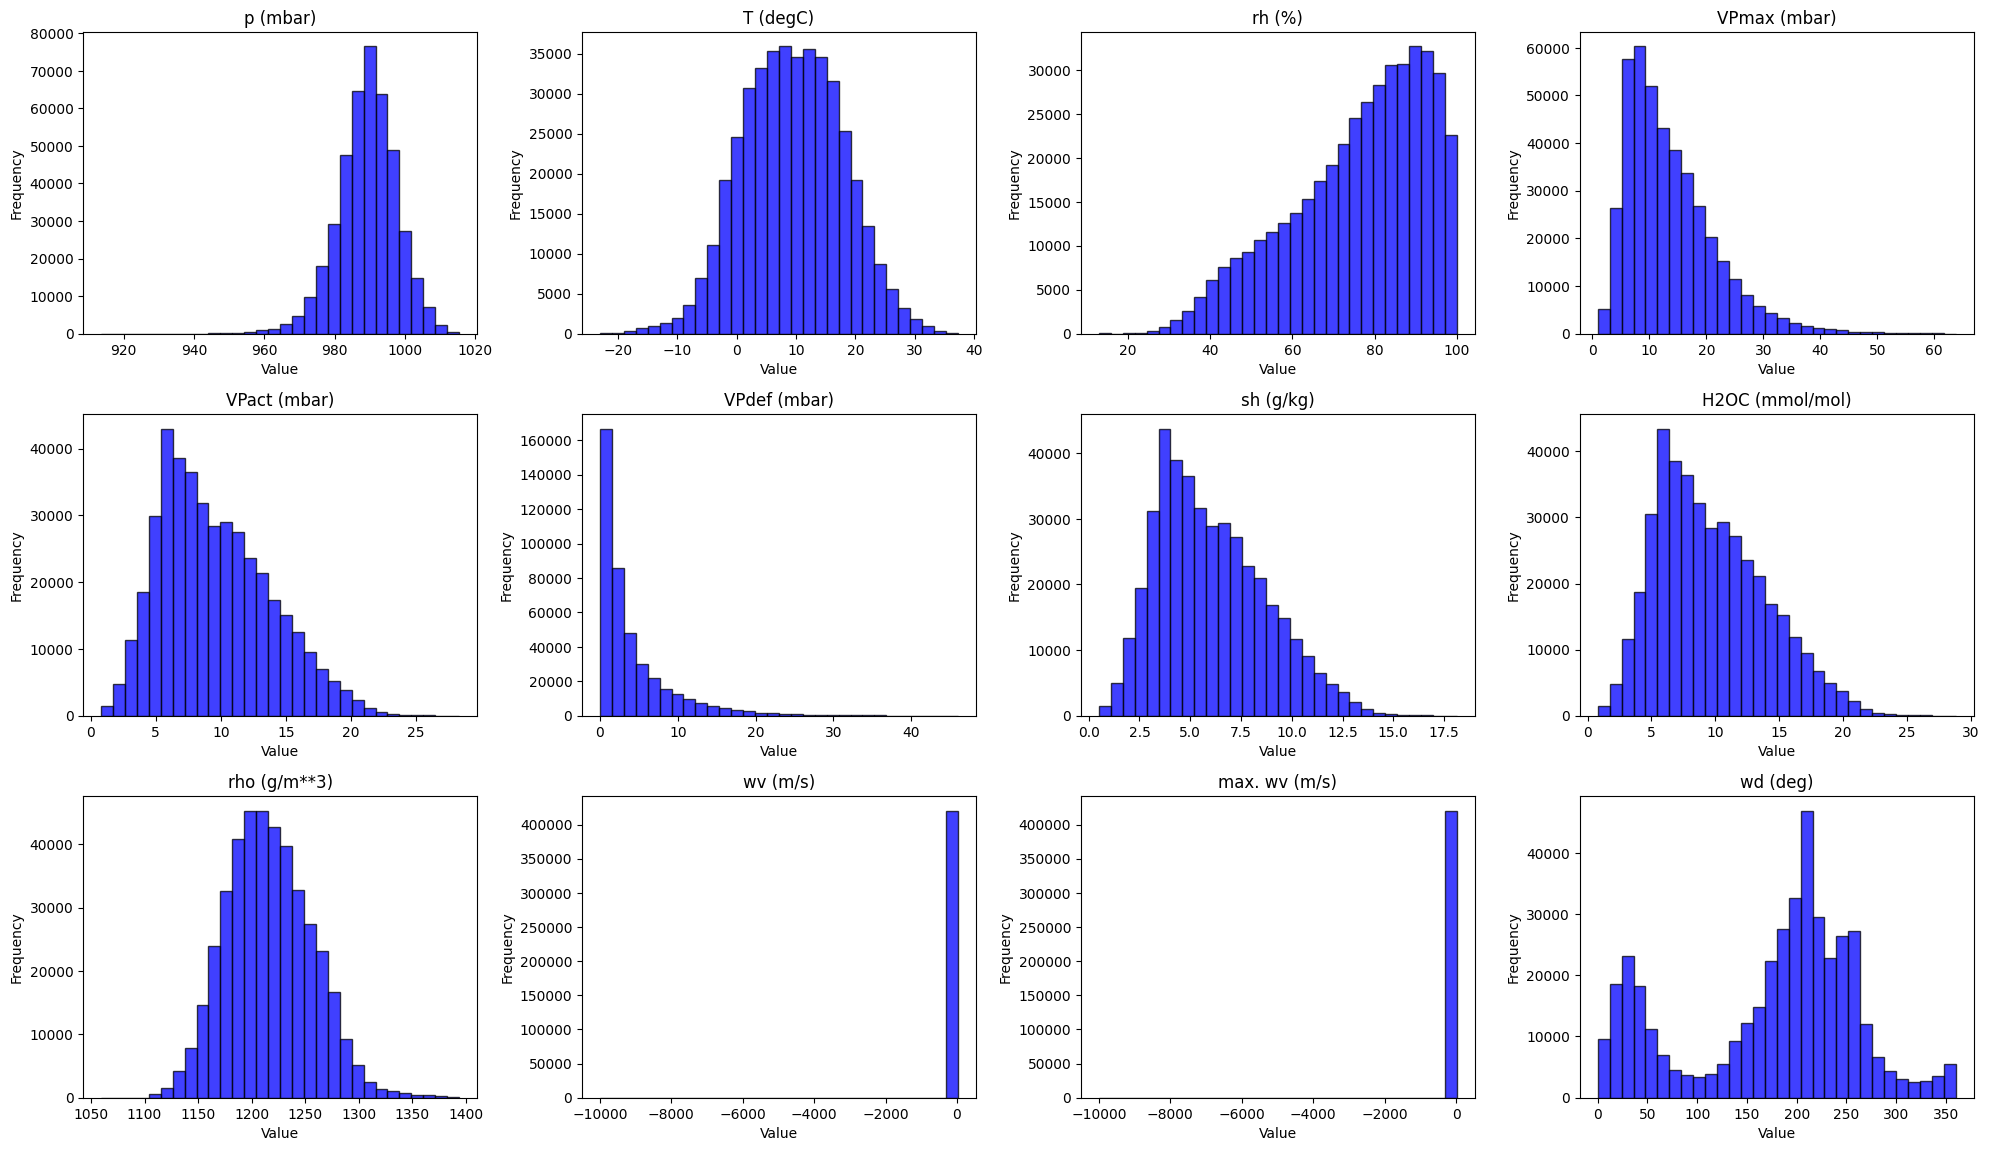

In [ ]:
import matplotlib.pyplot as plt

# Select columns excluding ['Tpot (K)', 'Tdew (degC)', 'Date Time']
excluded_columns = ['Tpot (K)', 'Tdew (degC)', 'Date Time']
columns_to_plot = [col for col in data.columns if col not in excluded_columns]

# Plot distributions for the selected columns
plt.figure(figsize=(20, 15))
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(4, 4, i)  # Adjust grid size based on the number of columns
    plt.hist(data[column].dropna(), bins=30, alpha=0.75, color='blue', edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


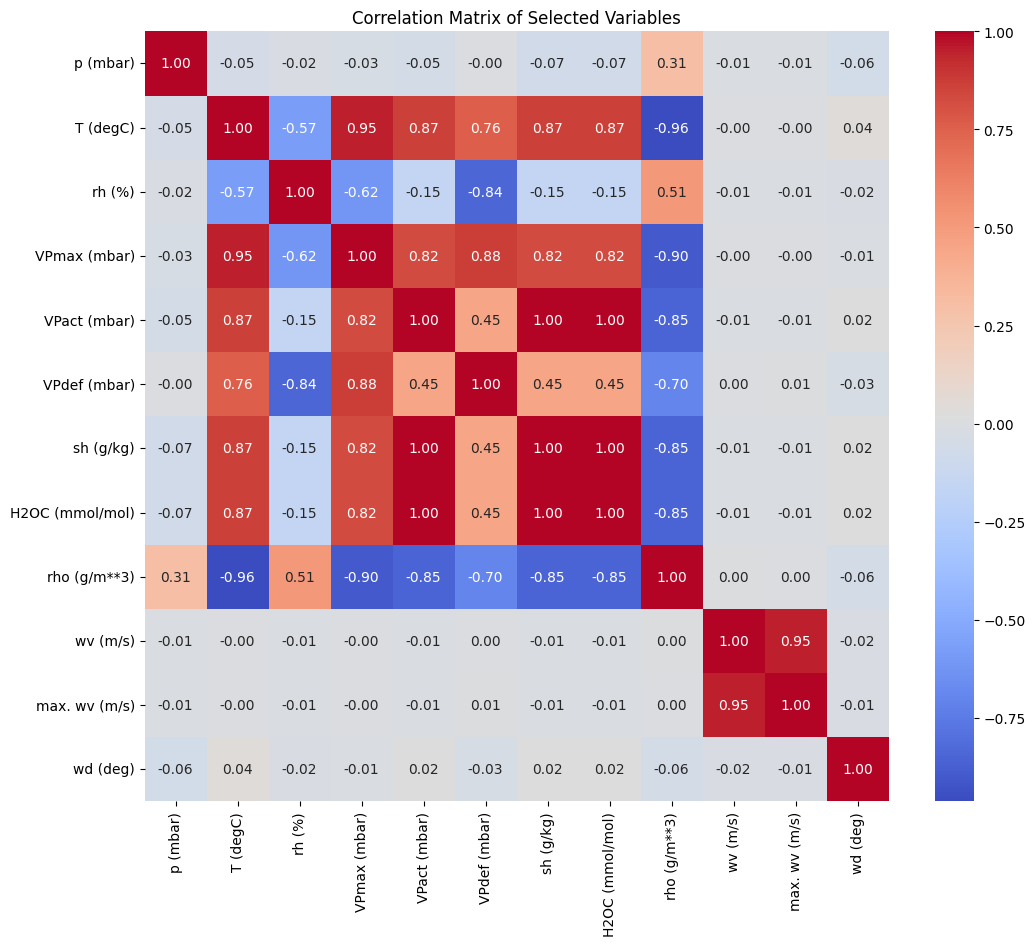

In [ ]:
import seaborn as sns

# Compute the correlation matrix for the selected columns
correlation_matrix = data[columns_to_plot].corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Selected Variables")
plt.show()


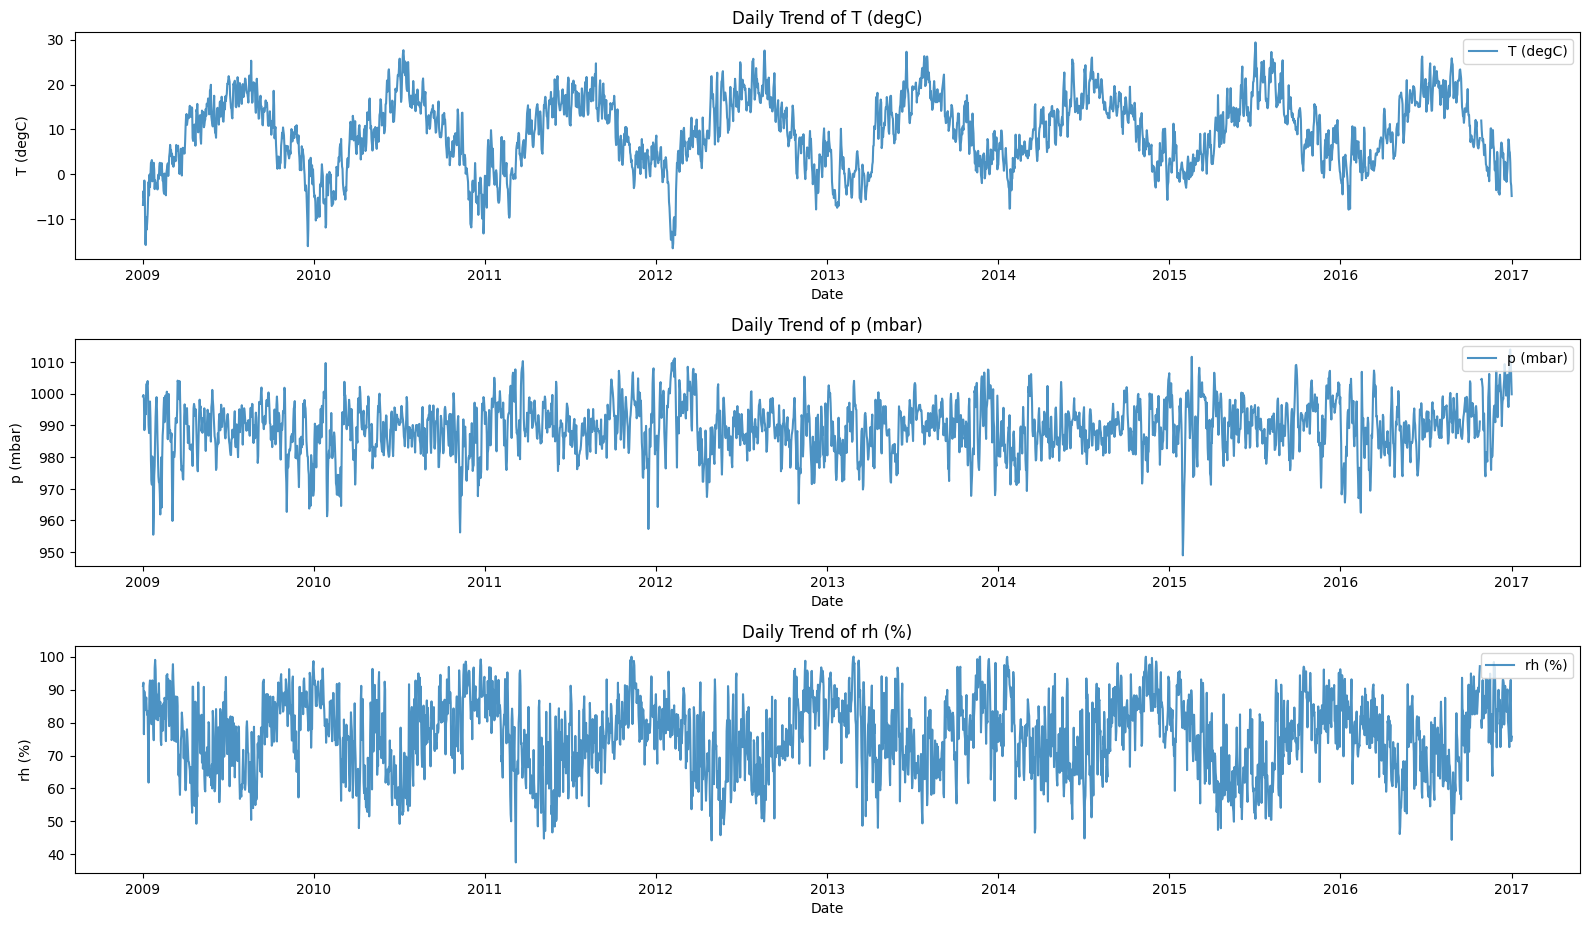

In [ ]:
# Convert 'Date Time' column to datetime format for time series analysis
data['Date Time'] = pd.to_datetime(data['Date Time'], format='%d.%m.%Y %H:%M:%S')

# Set 'Date Time' as the index
data.set_index('Date Time', inplace=True)

# Resample data to daily averages for trend analysis (reduces noise from high-frequency data)
daily_data = data.resample('D').mean()

# Plot time series trends for a few key variables
variables_to_plot = ['T (degC)', 'p (mbar)', 'rh (%)']

plt.figure(figsize=(16, 12))
for i, variable in enumerate(variables_to_plot, 1):
    plt.subplot(4, 1, i)
    plt.plot(daily_data[variable], label=variable, alpha=0.8)
    plt.title(f"Daily Trend of {variable}")
    plt.xlabel('Date')
    plt.ylabel(variable)
    plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


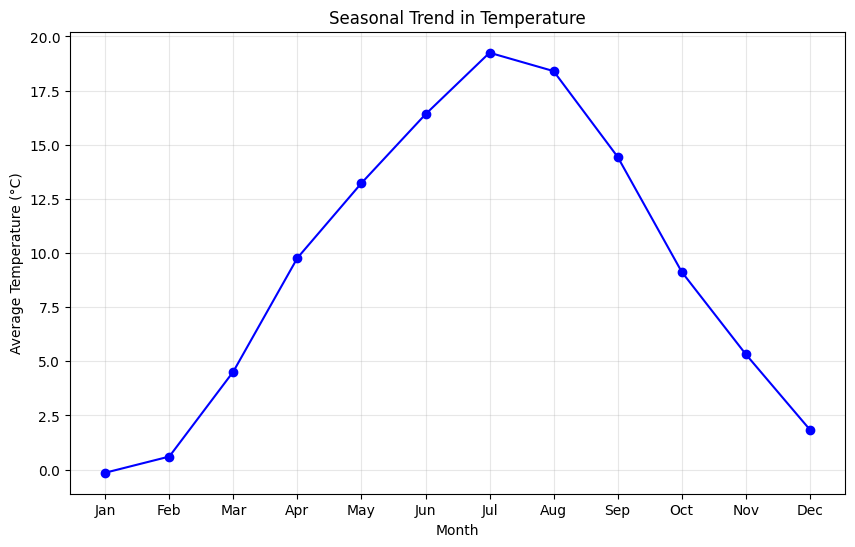

In [ ]:
# Extract month and year for seasonal analysis
daily_data['Month'] = daily_data.index.month
daily_data['Year'] = daily_data.index.year

# Group by month to calculate the mean temperature for each month
monthly_seasonal_data = daily_data.groupby('Month')['T (degC)'].mean()

# Plot seasonal trend in temperature
plt.figure(figsize=(10, 6))
plt.plot(monthly_seasonal_data.index, monthly_seasonal_data.values, marker='o', linestyle='-', color='blue')
plt.title("Seasonal Trend in Temperature")
plt.xlabel("Month")
plt.ylabel("Average Temperature (°C)")
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(alpha=0.3)
plt.show()
